# The following code is used to generate Figure 2, Figure S1, Figure S5 and Figure 6S from "Storms drive CO2 outgassing in the subpolar Southern Ocean"


Author: Sarah-Anne Nicholson
Date: 03-Nov-2021

In [1]:
%pylab inline
import glidertools as gt
import xarray as xr
import pandas as pd
import seawater as sw
import cmocean as cmo
import seaborn as sns
from scipy import stats
from PyCO2SYS import CO2SYS
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoMinorLocator
from scipy.optimize import curve_fit
from scipy import integrate
from sklearn.linear_model import LinearRegression
import gsw
import seaflux as sf

Populating the interactive namespace from numpy and matplotlib


# LOAD time-series data


In [2]:
WG=pd.read_csv('../Data/SOSCEx_STORM2_Glider_Data/WG_and_timeseries_nicholson_etal_2021.csv',index_col=0)

# Load SLOCUM data

In [11]:
sl = xr.open_dataset('../Data/SOSCEx_STORM2_Glider_Data/slocum_data.nc')

# Load microstructure data

In [10]:
eps = xr.open_dataset('../Data/SOSCEx_STORM2_Glider_Data/EPSFINAL_soscex_storm2.nc')

# function to find isopycnal

In [12]:

ref_eps = 1026.5
def find_ref_iso(eps, depth, ref_eps=1026.4 ):
    if eps.size==0: # for empty
        return nan
    else: absdiff = np.abs(eps - ref_eps)
    eps_idx = absdiff.idxmin()
    ref_depth = depth[eps_idx]
    if isnan(eps).all():
        return nan
    else:
         return ref_depth

grp = sl.to_dataframe().groupby('dives')

ref_eps = 1027.3
iso1 = grp.apply(lambda s: find_ref_iso(s.Potential_Density.dropna(), s.depth, ref_eps))
iso1[iso1>300]=np.nan

# Intertial period

In [14]:
def coriolis(lat):  
    omega   = 7.2921159e-05  # angular velocity of the Earth [rad/s]
    return 2*omega*np.sin(lat/360.*2*np.pi)

# Inertial period (used for smoothing later)
f = coriolis(-54) # seconds
T = int(np.round(2*pi/np.abs(f)/3600))


In [16]:
rcParams['savefig.dpi'] = 500
cm = 1/2.54  # centimeters in inches
rcParams['figure.figsize'] = [18.5*cm, 12.1*cm]
sns.set_style("white")
rcParams['font.size'] = 7
rcParams['font.family'] = 'Arial'
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
weeks = mdates.WeekdayLocator(interval=1)
days = mdates.DayLocator(interval=1)
hrs = mdates.HourLocator(interval=1)
daysFmt = mdates.DateFormatter("%h")
yearsFmt = mdates.DateFormatter("%d\%m")

# FIGURE 2

Mean bin size = 1.00
Mean depth binned (50 m) vertical sampling frequency = 0.13


<ipython-input-17-ea67870f9b24>:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


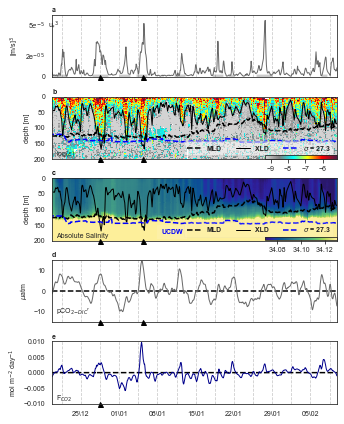

In [17]:
#Lewis and Wallace (1998)
tf = 7 # title fontsize
cm = 1/2.54 
t = np.unique(sl.date_av) #pd.to_datetime(WG.Date.values)
T2 = np.round(T/2,0)
fig8 = plt.figure(figsize=(12.1*cm, 15*cm))


#=================================
ax1 = fig8.add_subplot(511)
#=================================
ax1.plot(pd.to_datetime(WG.Date.values),WG.ustar_ms**3,color='dimgrey',lw=1)
ax1.text(t[0],4.8e-05 ,'u$_{*}$$^3$',fontsize=tf)
ax1.set_title('a',loc='left',fontsize=tf,position=(0, .95),fontweight='bold')
ax1.set_ylabel('[m/s]$^3$')
ax1.tick_params(labelbottom=False)    
ax1.set_xlim(t[12], t[-263])
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax1.xaxis.grid(True,ls='--')
ax1.xaxis.set_major_locator(weeks)
ax1.xaxis.grid(True,ls='--')
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor',ls='--')
plt.yticks([0,0.00002,0.000050],['0','2e$^{-05}$','5$e^{-5}$'])
plt.axvspan(pd.to_datetime('2018-12-19'), pd.to_datetime('2018-12-22 12H'),0,.06, facecolor='k', alpha=0.2)
plt.axvspan(pd.to_datetime('2018-12-27'), pd.to_datetime('2018-12-30'),0,0.06, facecolor='k', alpha=0.2)
plt.axvspan(pd.to_datetime('2019-01-01'), pd.to_datetime('2019-01-03'),0,0.06, facecolor='k', alpha=0.2)
plt.axvspan(pd.to_datetime('2019-01-04'), pd.to_datetime('2019-01-06'),0,0.06, facecolor='k', alpha=0.2)
plt.axvspan(pd.to_datetime('2019-01-11'), pd.to_datetime('2019-01-13'),0,0.06, facecolor='k', alpha=0.2)
plt.axvspan(pd.to_datetime('2019-01-18'), pd.to_datetime('2019-01-20'),0,0.06, facecolor='k', alpha=0.2)
plt.axvspan(pd.to_datetime('2019-01-26'), pd.to_datetime('2019-01-29'),0,0.06, facecolor='k', alpha=0.2)
plt.axvspan(pd.to_datetime('2019-01-21'), pd.to_datetime('2019-01-22'),0,0.06, facecolor='k', alpha=0.2)
plt.axvspan(pd.to_datetime('2019-02-07'), pd.to_datetime('2019-02-08'),0,0.06, facecolor='k', alpha=0.2)
ax1.plot(t[103],-0.000001,'^',zorder=100,color='k',clip_on=False,markersize=5)
ax1.plot(t[185],-0.000001,'^',zorder=100,color='k',clip_on=False,markersize=5)
plt.ylim(-0.000001,0.00006)


#=================================
ax2 = fig8.add_subplot(512)
#=================================
EPSGz = np.reshape(eps.EPS_FINAL.values,[200, 391])
EPSDEP = np.reshape(eps.DEPTH.values,[200, 391])
EPSTIME = np.reshape(eps.TIME_EPSFINAL.values,[200, 391])

from matplotlib.colors import LinearSegmentedColormap 
custom= []
cmap1 = LinearSegmentedColormap.from_list(custom, colors =['lightgrey','grey','aqua','yellow','red','#581845'],N=256)
cm = ax2.pcolormesh(EPSTIME,EPSDEP,log10(EPSGz),cmap=cmap1,vmin=-9.3,vmax=-5.2); 
axins = inset_axes(ax2,
                   width="25%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower right',bbox_to_anchor=(0, 0., 1.0, 1.2),
                   bbox_transform=ax2.transAxes,
                   borderpad=0.03,
                   )
fig8.colorbar(cm, cax=axins, ticks=[-5,-6,-7, -8,-9],orientation='horizontal')
ax2.plot(pd.to_datetime(WG.Date.values),WG.mld003_slocum_m.rolling(T).mean().bfill().values,'--k',lw=1.5,label='MLD')
ax2.plot(pd.to_datetime(WG.Date.values),WG.xld_slocum_m.values,'-k',lw=1,label='XLD')
ax2.plot(t,iso1.rolling(T*2).mean().bfill().values,'--b',lw=1.5,label='$\sigma$ = 27.3')

ax2.tick_params(labelbottom=False)    
legend_properties = {'weight':'bold'}
ax2.legend(fontsize=7,prop=legend_properties,ncol=3,framealpha=0.5,loc=4)
ax2.set_ylim(200,0)
ax2.set_xlim(t[12],t[-263])
ax2.set_xlabel('')
ax2.text(pd.to_datetime(t[20]),190 ,'log($\epsilon$)',fontsize=tf)
ax2.set_title('b',loc='left',fontsize=tf,position=(0, .95),fontweight='bold')
ax2.set_ylabel('depth [m]')
ax2.xaxis.set_major_locator(weeks)
ax2.xaxis.grid(True,ls='--')
ax2.plot(t[103],200,'^',zorder=100,color='k',clip_on=False,markersize=5)
ax2.plot(t[185],200,'^',zorder=100,color='k',clip_on=False,markersize=5)



#=================================
ax3 = fig8.add_subplot(514) 
#=================================
ax3.plot(pd.to_datetime(WG.Date.values),WG.PCO2_DIC_anom_muatm*0,'--k')
ax3.plot(pd.to_datetime(WG.Date.values),WG.PCO2_DIC_anom_muatm.rolling(int(T2),center=True,min_periods=2).mean(),color='dimgrey',lw=1)
ax3.text(pd.to_datetime(t[20]),-11 ,'pCO$_{2}$$_{-DIC}$\u2032',fontsize=tf)
ax3.set_title('d',loc='left',fontsize=tf,position=(0, .95),fontweight='bold')
ax3.set_ylabel('$\mu$atm')
ax3.set_xlim(t[12],t[-263])
ax3.set_xlabel('')
ax3.tick_params(labelbottom=False)  
ax3.xaxis.grid(True)
ax3.xaxis.set_major_locator(weeks)
ax3.xaxis.grid(True,ls='--')
minor_locator = AutoMinorLocator(2)
ax3.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor',ls='--')
ax3.set_ylim(-15,15)
ax3.plot(t[103],-15,'^',zorder=100,color='k',clip_on=False,markersize=5)
ax3.plot(t[185],-15,'^',zorder=100,color='k',clip_on=False,markersize=5)


#=================================
ax4 = fig8.add_subplot(513) 
#=================================
salt_grid_abs = gt.grid_data(sl.dives,sl.depth,sl.Absolute_Salinity,bins=np.arange(0,1000,1))
salt_grid_smooth = salt_grid_abs.rolling(dives = 9,center=True,min_periods=2).mean()
cm = ax4.pcolormesh(t,salt_grid_smooth.depth,salt_grid_smooth,vmin=34.07,vmax=34.13,cmap=cmo.cm.haline)#'PuBuGn');
axins = inset_axes(ax4,
                   width="25%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50%
                   loc='lower right',bbox_to_anchor=(0, 0., 1.0, 1.2),
                   bbox_transform=ax4.transAxes,
                   borderpad=0.03,
                   )
fig8.colorbar(cm, cax=axins, ticks=[34.08,34.1,34.12],orientation='horizontal')
ax4.set_ylim(200,0)
ax4.plot(pd.to_datetime(WG.Date.values),WG.mld003_slocum_m.rolling(T).mean().bfill().values,'--k',lw=1.5,label='MLD')
ax4.plot(pd.to_datetime(WG.Date.values),WG.xld_slocum_m.values,'-k',lw=1,label='XLD')
ax4.plot(t,iso1.rolling(T*2).mean().bfill().values,'--b',lw=1.5,label='$\sigma$ = 27.3')
ax4.set_xlim(t[12],t[-263])
ax4.tick_params(labelbottom=False) 
ax4.text(pd.to_datetime(t[20]),190 ,'Absolute Salinity',fontsize=tf)
ax4.set_title('c',loc='left',fontsize=tf,position=(0.0, 0.95),fontweight='bold',color='k')
ax4.set_ylabel('depth [m]')
ax4.text(t[220],180,'UCDW',color='blue',fontweight='bold',fontsize=7,bbox=dict(facecolor='white', alpha=0.12,lw=0))
ax4.xaxis.set_major_locator(weeks)
ax4.xaxis.grid(True,ls='--')
minor_locator = AutoMinorLocator(2)
ax4.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor',ls='--')
ax4.xaxis.set_major_locator(weeks)
ax4.xaxis.grid(True,ls='--')
ax4.legend(fontsize=7,prop=legend_properties,ncol=3,framealpha=0.12,loc=4)
ax4.plot(t[103],200,'^',zorder=100,color='k',clip_on=False,markersize=5)
ax4.plot(t[185],200,'^',zorder=100,color='k',clip_on=False,markersize=5)



#=================================
ax5 = fig8.add_subplot(515) 
#=================================
ax5.plot(pd.to_datetime(WG.Date.values),WG.CO2_flux_WG_molm2day1*0,'--k')
ax5.plot(pd.to_datetime(WG.Date.values),WG.CO2_flux_WG_molm2day1.rolling(int(T2),center=True,min_periods=2).mean(),color='darkblue',lw=1)
ax5.text(pd.to_datetime(t[20]),-0.009 ,'F$_{CO2}$',fontsize=tf)
#ax5.tex('F$_{CO2}$ ',0.01, 0.8,fontsize=tf)
ax5.set_title('e',loc='left',fontsize=tf,position=(0.0, 0.95),fontweight='bold')
ax5.set_ylabel('mol m$^{-2}$ day$^{-1}$')
ax5.set_xlim(t[12],t[-263])
ax5.set_ylim(-0.01,0.01)
ax5.xaxis.set_major_formatter(yearsFmt)
ax5.xaxis.set_major_locator(weeks)
ax5.xaxis.grid(True,ls='--')
minor_locator = AutoMinorLocator(2)
ax5.xaxis.set_minor_locator(minor_locator)
plt.grid(which='minor',ls='--')
ax5.plot(t[103],-0.01,'^',color='k',clip_on=False,markersize=5)
#ax5.plot(t[185],-0.01,'^',color='k',clip_on=False,markersize=5)
plt.tight_layout()

#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=True)

#plt.savefig('/Users/sarahnicholson/Dropbox/DEPLOYMENTS_EXPERIMENTS/SOSCEx_STORM2/REVIEWER_RESPONSE1/FINAL_VERSION/Figure_2.pdf')
#plt.savefig('/Users/sarahnicholson/Dropbox/DEPLOYMENTS_EXPERIMENTS/SOSCEx_STORM2/PAPER_FIGURES/SUBMISSION_NATURECOMMS/Figure_2.png',dpi=500)

# SUPPLEMENTARY 1:

## FIGURES S1

Text(0, 0.5, '$\\mu$atm')

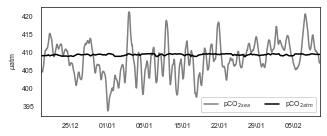

In [20]:
plt.figure(figsize=(5,2))
ax1= plt.subplot(111)
yearsFmt1 = mdates.DateFormatter("%d\%m")
plot(pd.to_datetime(WG.Date),WG.pCO2sea_uatm.rolling(8,center=True,min_periods=2).mean(),color='grey',label='pCO$_{2sea}$')
plot(pd.to_datetime(WG.Date),WG.pCO2atm_uatm.rolling(8,center=True,min_periods=2).mean(),color='k',label='pCO$_{2atm}$')
plt.xlim(pd.to_datetime(WG.Date.values[10]),pd.to_datetime(WG.Date.values[-50]))
ax1.xaxis.set_major_locator(weeks)
ax1.xaxis.set_major_formatter(yearsFmt)
plt.legend(ncol=2,fontsize=7)
plt.ylabel('$\mu$atm')

# FIGURES S5

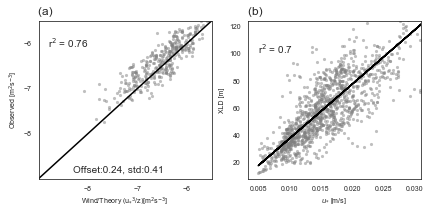

In [21]:
fig8=plt.figure(figsize=(6,3))
ax5 = fig8.add_subplot(121)
#=================================

# T = local inertial period of 15 hours
EPSGz = np.reshape(eps.EPS_FINAL.values,[200, 391])
EPSwscGz =  np.reshape(eps.EPS_THEORY.values,[200, 391])
EPSTHobs = np.nanmean(EPSGz[6:15,:],0);
EPSTHts = np.nanmean(EPSGz[6:15,:]/EPSwscGz[6:15,:],0);
datag = {'eps_datenum': np.reshape(eps.TIME_EPSFINAL.values,[200, 391])[10,:]-366,'eps_obs': EPSTHobs,'eps_theory':EPSTHts}
epg = pd.DataFrame(datag)
eps_smoth = epg.eps_obs.rolling(int(np.round(T/4)),center=True, min_periods=2).mean()
eps_th = epg.eps_theory.rolling(int(np.round(T/4)),center=True, min_periods=2).mean()

x = log10(eps_th[~np.isnan(eps_th)])
y = log10(eps_smoth[~np.isnan(eps_smoth)])
ax5.scatter(x,y,s=10,color='grey',alpha=0.5,lw=0); 
ax5.set_xlabel('Wind/Theory (u$_{*}$$^3$/z)[m$^2$s$^{-3}$]')
ax5.set_ylabel('Observed [m$^2$s$^{-3}$]')
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
y1 = slope*x + intercept
offset = np.nanmean(log10(eps_smoth[~isnan(eps_smoth)]/EPSTHts[~isnan(eps_smoth)]))
offset_std = np.std(log10(eps_smoth[~isnan(eps_smoth)]/EPSTHts[~isnan(eps_smoth)]))
ax5.text(-8.8,-6.1,'r$^2$ = '+str(np.round(r_value**2,2)),fontsize=10)
ax5.text(-8.3,-8.85,'Offset:'+ str(np.round(offset,2)) +', std:'+ str(np.round(offset_std,2)),fontsize=10)
ax5.set_title( '(a) ',fontsize=12,loc='left') #$\epsilon$ log10(m$^2$ s$^{-3}$)
ax5.set_xticks([-5,-6,-7,-8])
ax5.set_yticks([-5,-6,-7,-8])
ax5.set_xlim(-9,-5.5)
ax5.set_ylim(-9,-5.5)
xi=np.arange(-9,-4,1)
yi=np.arange(-9,-4,1)
ax5.plot(xi,yi,'k')


#=================================
ax6 = fig8.add_subplot(122)
#=================================
m = (np.isnan(WG.ustar_ms) | (np.isnan(WG.xld_slocum_m)))== True
x = WG.ustar_ms[~m].rolling(int(np.round(T/4)),center=True,min_periods=2).mean().bfill()#.ffill()#*3683.7917217699533 + 3.5
y = WG.xld_slocum_m[~m].rolling(int(np.round(T/4)),center=True,min_periods=2).mean().bfill()#.ffill()
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
ax6.scatter(x,y,s=10,color='grey',alpha=0.5,lw=0)
y1 = slope*x + intercept
ax6.plot(x,y1,color='k')
ax6.set_title('(b) ',fontsize=12,loc='left')
ax6.text(0.005,100,'r$^2$ = '+str(np.round(r_value**2,2)),fontsize=10)
ax6.set_ylabel('XLD [m]')
ax6.set_xlabel('$u_{*}$ [m/s]')
ax6.set_xlim(0.0033,.031)
ax6.set_ylim(8,124)
plt.tight_layout()
#plt.savefig('/Users/sarahnicholson/Dropbox/DEPLOYMENTS_EXPERIMENTS/SOSCEx_STORM2/PAPER_FIGURES/supplementary/Figure_S5.png',dpi=500)

## FIGURE S6

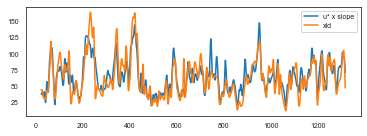

In [22]:
m= (np.isnan(WG.ustar_ms) | (np.isnan(WG.xld_slocum_m)))== True
x = WG.ustar_ms[~m].rolling(4,center=True).mean().bfill().ffill()#*3683.7917217699533 + 3.5
yy = WG.xld_slocum_m[~m].rolling(4,center=True).mean().bfill().ffill()
figure(figsize=(6,2))
slope_ustar, intercept, r_value, p_value, std_err = stats.linregress(x,yy)
y1 = slope_ustar*x + intercept
plt.subplot(111)
plot(x*slope_ustar,label='u* x slope')
plot(yy,label='xld')
plt.legend()